In [1]:
import os; os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
from tqdm.auto import tqdm

from pathlib import Path
import numpy as np
import pandas as pd
import scipy
from pickle import dump, load
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import clear_output
import tensorflow as tf
# import plotly.express as px
from tensorflow.keras import layers
from PIL import Image
import re

import torch
import piq

# Pequeñas pruebas con las métricas

In [32]:
sample_img_1, sample_img_2 = torch.rand(size=(2,3,56,56))
sample_img_1.shape, sample_img_2.shape

(torch.Size([3, 56, 56]), torch.Size([3, 56, 56]))

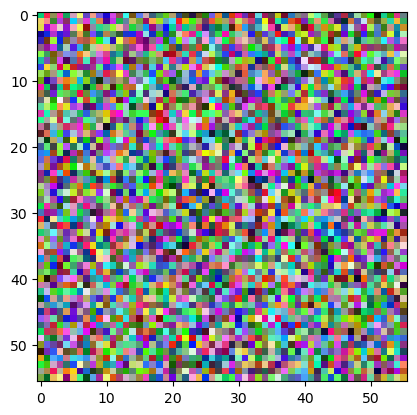

In [33]:
plt.imshow(sample_img_2.permute(2,1,0))
plt.show()

In [34]:
metric = piq.LPIPS(reduction="mean", mean=[0., 0., 0.], std=[1., 1., 1.,])

In [35]:
metric(sample_img_1[None,:], sample_img_2[None,:])

tensor(0.2960)

In [79]:
mago = Image.open("./Images/Mago.png")
mago1 = Image.open("./Images/Mago1.png")
mago1 = mago1.resize((248, 302))
mago2 = Image.open("./Images/Mago2.png")

In [80]:
mago = np.array(mago)/255
mago1 = np.array(mago1)/255
mago2 = np.array(mago2)/255

In [81]:
mago.shape, mago1.shape, mago2.shape

((302, 248, 4), (302, 248, 4), (302, 248, 4))

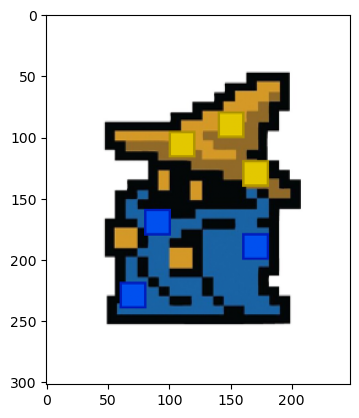

In [82]:
plt.imshow(mago1)

In [83]:
mago = torch.from_numpy(mago).permute(2,0,1)
mago1 = torch.from_numpy(mago1).permute(2,0,1)
mago2 = torch.from_numpy(mago2).permute(2,0,1)

In [84]:
mago.shape, mago1.shape, mago2.shape

(torch.Size([4, 302, 248]),
 torch.Size([4, 302, 248]),
 torch.Size([4, 302, 248]))

In [91]:
met_SSIM = piq.ssim(mago[None,:], mago2[None,:],reduction="none")
met_SSIM

tensor([0.9597], dtype=torch.float64)

# MNIST

In [3]:
(Xtrain, Ytrain), (Xtest, Ytest) = tf.keras.datasets.mnist.load_data()
Xtrain = Xtrain / 255
Xtest = Xtest / 255
Xtrain = np.expand_dims(Xtrain,-1)
Xtest = np.expand_dims(Xtest,-1)

In [4]:
Xtrain_big = np.zeros((Xtrain.shape[0],56,56,1))
Xtrain_big[:,14:14+28,14:14+28] = Xtrain[:,:,:]

Xtest_big = np.zeros((Xtest.shape[0],56,56,1))
Xtest_big[:,14:14+28,14:14+28] = Xtest[:,:,:]


In [37]:
dst_train = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain)).batch(128)

In [15]:
img, label = next(iter(dst_train))
img.shape, label.shape

(TensorShape([32, 28, 28, 1]), TensorShape([32]))

In [12]:
def var_pos(X, desp_h, desp_v):
  X_big = np.zeros((X.shape[0],56,56,1))
  X_big[:,14+desp_v:14+28+desp_v,14+desp_h:14+28+desp_h] = X[:,:,:]
  return X_big

In [15]:
torch.from_numpy(Xtrain_big).shape, torch.from_numpy(Xtrain_big).permute(0,3,2,1).shape

(torch.Size([60000, 56, 56, 1]), torch.Size([60000, 1, 56, 56]))

In [21]:
metric_LPIPS = piq.LPIPS(reduction="none", mean=[0., 0., 0.], std=[1., 1., 1.,])


for img, label in dst_train:    
    img_desp = var_pos(img, desp_h = 4, desp_v = 4)
    img = var_pos(img, desp_h=0, desp_v=0)
    img = torch.from_numpy(img)
    img_desp = torch.from_numpy(img_desp)
    met_LPIPS = metric_LPIPS(img.permute(0,3,1,2), img_desp.permute(0,3,1,2))
    break

In [ ]:
desps_h = range(-10,11)
desps_v = range(-10,11)
metric_LPIPS = piq.LPIPS(reduction="none", mean=[0., 0., 0.], std=[1., 1., 1.,])
metric_DISTS = piq.LPIPS(reduction="none", mean=[0., 0., 0.], std=[1., 1., 1.,])
#metric_SSIM = piq.ssim(reduction="none")
metricas = {}
 
for desp_h in tqdm(desps_h):
    for desp_v in tqdm(desps_v):
        metricas[(desp_h, desp_v)] = {"LPIPS":[], "DISTS":[], "SSIM":[]}
        for img, label in dst_train:    
            img_desp = var_pos(img, desp_h = desp_h, desp_v = desp_v)
            img = var_pos(img, desp_h=0, desp_v=0)
            img = torch.from_numpy(img)
            img_desp = torch.from_numpy(img_desp)
            met_LPIPS = metric_LPIPS(img.permute(0,3,1,2), img_desp.permute(0,3,1,2))
            met_DISTS = metric_DISTS(img.permute(0,3,1,2), img_desp.permute(0,3,1,2))
            met_SSIM = piq.ssim(img.permute(0,3,1,2), img_desp.permute(0,3,1,2),reduction="none")
            metricas[(desp_h, desp_v)]["LPIPS"].extend(met_LPIPS)
            metricas[(desp_h, desp_v)]["DISTS"].extend(met_DISTS)
            metricas[(desp_h, desp_v)]["SSIM"].extend(met_SSIM)
            
        break
    break


In [49]:
len(metricas[(-10, -10)]["SSIM"])

60000

In [51]:
df_metricas = pd.DataFrame.from_dict(metricas, orient="index").reset_index()
df_metricas.columns = ["desp_h","desp_v", "LPIPS", "DISTS", "SSIM"]

In [52]:
df_metricas

,desp_h,desp_v,LPIPS,DISTS,SSIM
0,-10,-10,"[tensor(0.2446, dtype=torch.float64), tensor(0...","[tensor(0.2446, dtype=torch.float64), tensor(0...","[tensor(0.5552, dtype=torch.float64), tensor(0..."


# Lectura de métricas

In [17]:
IQA = pd.read_csv("IQA_metrics_TFM.csv")

In [18]:
def cell_to_list(cell): return [float(n) for n in re.findall("tensor\((-?[\d.]+(?:e-?\d+)?)", cell)]

In [26]:
recover_results = {}
for i, row in IQA.iterrows():
    values_LPIPS = cell_to_list(row.LPIPS)
    values_DISTS = cell_to_list(row.DISTS)
    values_SSIM = cell_to_list(row.SSIM)
    desp_h, desp_v = row.desp_h, row.desp_v
    recover_results[(desp_h, desp_v)] = {"LPIPS": values_LPIPS, "DISTS": values_DISTS, "SSIM": values_SSIM,}
    # break

In [27]:
recover_results = pd.DataFrame(recover_results).T

In [28]:
float(recover_results["DISTS"].iloc[220][0])

1.6596e-07

In [19]:
avg_results = {}
for i, row in IQA.iterrows():
    values_LPIPS = np.mean(cell_to_list(row.LPIPS))
    values_DISTS = np.mean(cell_to_list(row.DISTS))
    values_SSIM = np.mean(cell_to_list(row.SSIM))
    desp_h, desp_v = row.desp_h, row.desp_v
    avg_results[(desp_h, desp_v)] = {"LPIPS": values_LPIPS, "DISTS": values_DISTS, "SSIM": values_SSIM,}

std_results = {}
for i, row in IQA.iterrows():
    values_LPIPS = np.std(cell_to_list(row.LPIPS))
    values_DISTS = np.std(cell_to_list(row.DISTS))
    values_SSIM = np.std(cell_to_list(row.SSIM))
    desp_h, desp_v = row.desp_h, row.desp_v
    std_results[(desp_h, desp_v)] = {"LPIPS": values_LPIPS, "DISTS": values_DISTS, "SSIM": values_SSIM,}


max_results = {}
for i, row in IQA.iterrows():
    values_LPIPS = np.max(cell_to_list(row.LPIPS))
    values_DISTS = np.max(cell_to_list(row.DISTS))
    values_SSIM = np.max(cell_to_list(row.SSIM))
    desp_h, desp_v = row.desp_h, row.desp_v
    max_results[(desp_h, desp_v)] = {"LPIPS": values_LPIPS, "DISTS": values_DISTS, "SSIM": values_SSIM,}


min_results = {}
for i, row in IQA.iterrows():
    values_LPIPS = np.min(cell_to_list(row.LPIPS))
    values_DISTS = np.min(cell_to_list(row.DISTS))
    values_SSIM = np.min(cell_to_list(row.SSIM))
    desp_h, desp_v = row.desp_h, row.desp_v
    min_results[(desp_h, desp_v)] = {"LPIPS": values_LPIPS, "DISTS": values_DISTS, "SSIM": values_SSIM,}

In [20]:
avg_results = pd.DataFrame(avg_results).T
std_results = pd.DataFrame(std_results).T
max_results = pd.DataFrame(max_results).T
min_results = pd.DataFrame(min_results).T


/tmp/uv0755/ipykernel_106492/3470668883.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_106492/3470668883.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


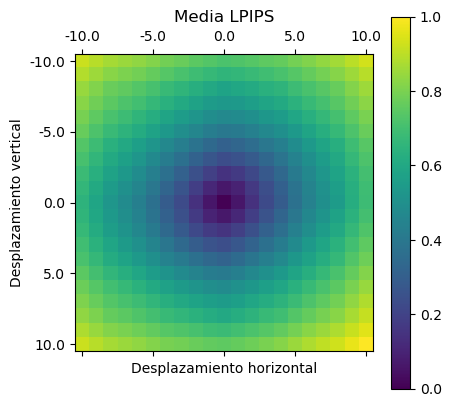

In [14]:
lpips = avg_results["LPIPS"].reset_index()
max = np.max(avg_results["LPIPS"])
m = np.zeros(shape=(21,21))
for i, row in lpips.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.LPIPS/max
    # m[i,j] = row.LPIPS if not np.isnan(row.LPIPS) else 0
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Media LPIPS")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_106492/1294967224.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_106492/1294967224.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


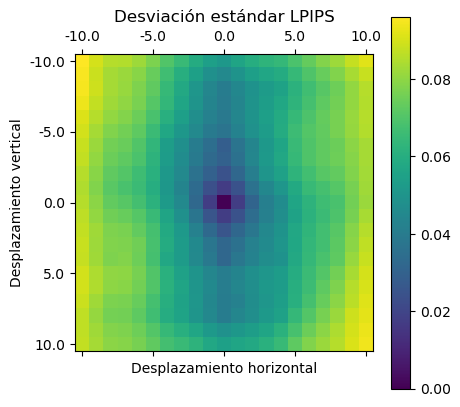

In [15]:
lpips2 = std_results["LPIPS"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in lpips2.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.LPIPS/max# if not np.isnan(row.LPIPS) else 0
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Desviación estándar LPIPS")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/1137754480.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/1137754480.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


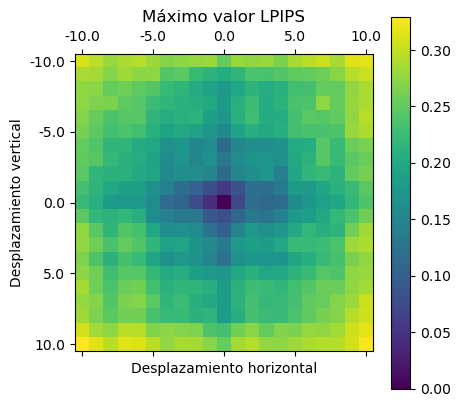

In [33]:
lpips3 = max_results["LPIPS"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in lpips3.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.LPIPS# if not np.isnan(row.LPIPS) else 0
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Máximo valor LPIPS")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/1348453051.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/1348453051.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


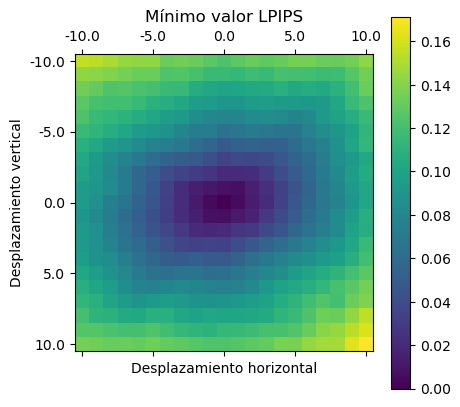

In [34]:
lpips4 = min_results["LPIPS"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in lpips4.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.LPIPS if not np.isnan(row.LPIPS) else 0
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Mínimo valor LPIPS")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

# DISTS

/tmp/uv0755/ipykernel_106492/3508443634.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_106492/3508443634.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


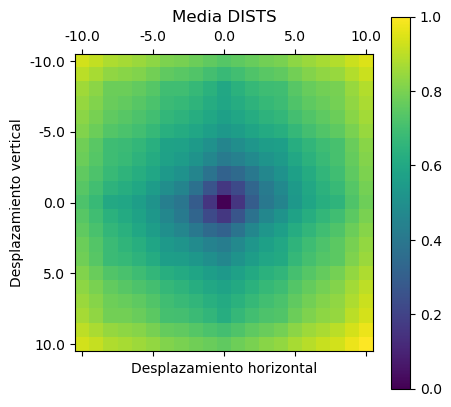

In [16]:
dists = avg_results["DISTS"].reset_index()
max= np.max(avg_results["DISTS"])
m = np.zeros(shape=(21,21))
for i, row in dists.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.DISTS/max# if not np.isnan(row.DISTS) else 0
m[10,10]=0
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Media DISTS")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_106492/3349387648.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_106492/3349387648.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


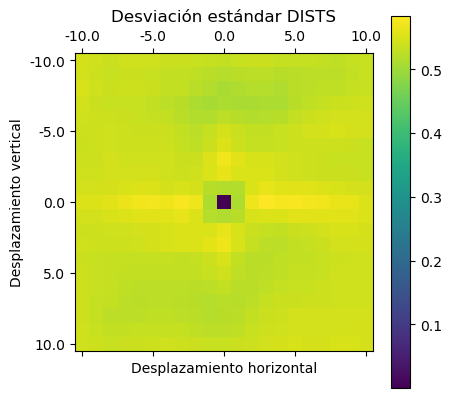

In [17]:
dists2 = std_results["DISTS"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in dists2.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.DISTS/max# if not np.isnan(row.DISTS) else 0
#m[10,10]=0
plt.matshow(m**0.2)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Desviación estándar DISTS")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/406804578.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/406804578.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


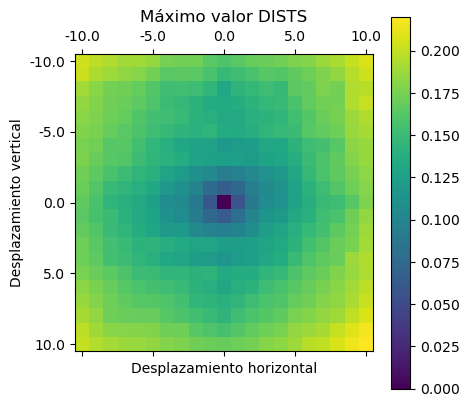

In [37]:
dists3 = max_results["DISTS"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in dists3.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.DISTS# if not np.isnan(row.LPIPS) else 0
m[10,10]=0
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Máximo valor DISTS")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/2882159544.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/2882159544.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


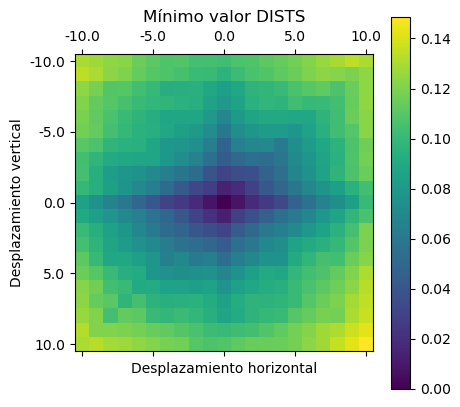

In [38]:
dists4 = min_results["DISTS"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in dists4.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.DISTS# if not np.isnan(row.LPIPS) else 0
m[10,10]=0
plt.matshow(m)
#plt.pcolor(X, Y, f(data), cmap=cm, vmin=-4, vmax=4)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Mínimo valor DISTS")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

# SSIM

/tmp/uv0755/ipykernel_114582/4198693254.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_114582/4198693254.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


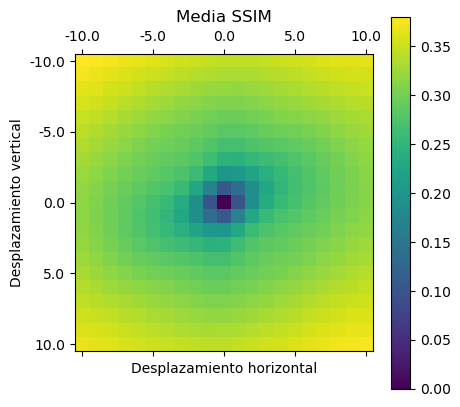

In [21]:
SSIM_avg = avg_results["SSIM"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in SSIM_avg.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = 1 - row.SSIM #if not np.isnan(row.SSIM) else 1
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Media SSIM")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
#plt.clim(0,1)
plt.show()

In [14]:
SSIM_avg["SSIM"]

0      0.380643
1      0.377955
2      0.374172
3      0.370005
4      0.365825
         ...   
436    0.364679
437    0.368579
438    0.372021
439    0.374432
440    0.375371
Name: SSIM, Length: 441, dtype: float64

In [15]:
SSIM_avg["SSIM"] = 1 - SSIM_avg["SSIM"]

In [16]:
SSIM_avg["SSIM"]

0      0.619357
1      0.622045
2      0.625828
3      0.629995
4      0.634175
         ...   
436    0.635321
437    0.631421
438    0.627979
439    0.625568
440    0.624629
Name: SSIM, Length: 441, dtype: float64

/tmp/uv0755/ipykernel_73428/1463030011.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/1463030011.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


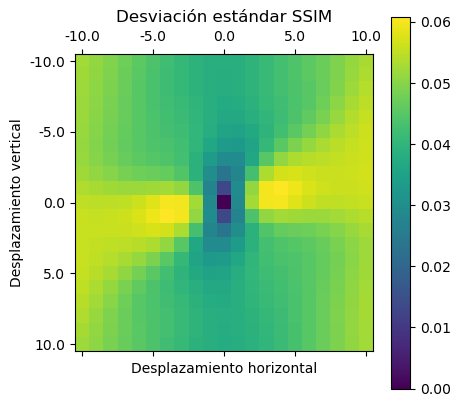

In [40]:
SSIM_std = std_results["SSIM"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in SSIM_std.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.SSIM #if not np.isnan(row.SSIM) else 0
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Desviación estándar SSIM")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
#plt.clim(0,1)
plt.show()

/tmp/uv0755/ipykernel_73428/1023855373.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/1023855373.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


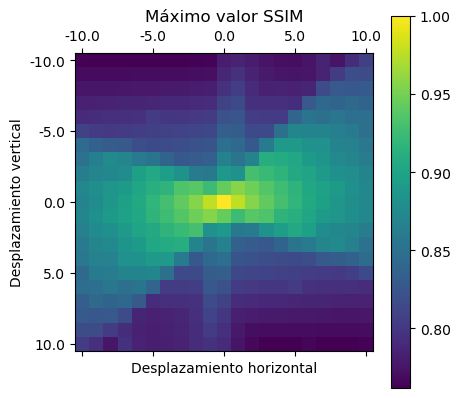

In [41]:
SSIM_max = max_results["SSIM"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in SSIM_max.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.SSIM #if not np.isnan(row.SSIM) else 0
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Máximo valor SSIM")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/476049411.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/476049411.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


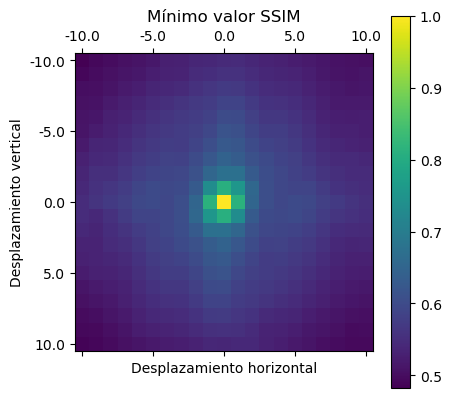

In [42]:
SSIM_min = min_results["SSIM"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in SSIM_min.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.SSIM #if not np.isnan(row.SSIM) else 0
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Mínimo valor SSIM")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

# MSE

In [54]:
IQA = pd.read_csv("IQA_metrics_TFM_PerceptNet_MSE.csv")
def cell_to_list(cell): return [float(n) for n in re.findall("-?[\d.]+(?:e-?\d+)?-?[\d.]+(?:e-?\d+)?", cell)]

In [55]:
avg_results = {}
for i, row in IQA.iterrows():
    values_MSE = np.mean(cell_to_list(row.MSE))
    values_PerceptNet = np.mean(cell_to_list(row.PerceptNet))
    desp_h, desp_v = row.desp_h, row.desp_v
    avg_results[(desp_h, desp_v)] = {"MSE": values_MSE, "PerceptNet": values_PerceptNet}

std_results = {}
for i, row in IQA.iterrows():
    values_MSE = np.std(cell_to_list(row.MSE))
    values_PerceptNet = np.std(cell_to_list(row.PerceptNet))
    desp_h, desp_v = row.desp_h, row.desp_v
    std_results[(desp_h, desp_v)] = {"MSE": values_MSE, "PerceptNet": values_PerceptNet}


max_results = {}
for i, row in IQA.iterrows():
    values_MSE = np.max(cell_to_list(row.MSE))
    values_PerceptNet = np.max(cell_to_list(row.PerceptNet))
    desp_h, desp_v = row.desp_h, row.desp_v
    max_results[(desp_h, desp_v)] = {"MSE": values_MSE, "PerceptNet": values_PerceptNet}


min_results = {}
for i, row in IQA.iterrows():
    values_MSE = np.min(cell_to_list(row.MSE))
    values_PerceptNet = np.min(cell_to_list(row.PerceptNet))
    desp_h, desp_v = row.desp_h, row.desp_v
    min_results[(desp_h, desp_v)] = {"MSE": values_MSE, "PerceptNet": values_PerceptNet}

In [56]:
avg_results = pd.DataFrame(avg_results).T
std_results = pd.DataFrame(std_results).T
max_results = pd.DataFrame(max_results).T
min_results = pd.DataFrame(min_results).T

/tmp/uv0755/ipykernel_73428/2188518402.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/2188518402.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


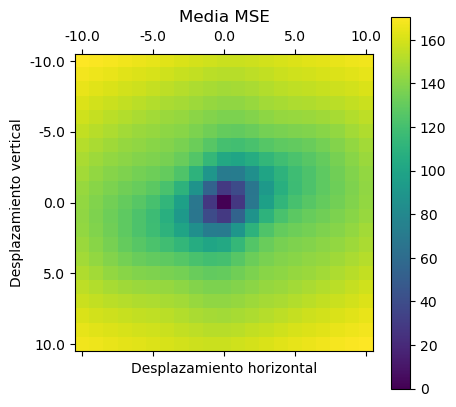

In [57]:
MSE_avg = avg_results["MSE"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in MSE_avg.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.MSE #if not np.isnan(row.SSIM) else 1
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Media MSE")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/869898350.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/869898350.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


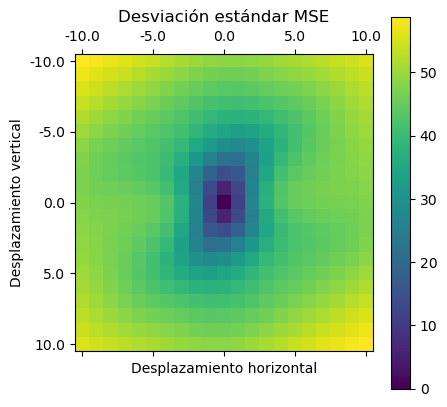

In [58]:
MSE_std = std_results["MSE"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in MSE_std.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.MSE #if not np.isnan(row.SSIM) else 1
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Desviación estándar MSE")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/2295376314.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/2295376314.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


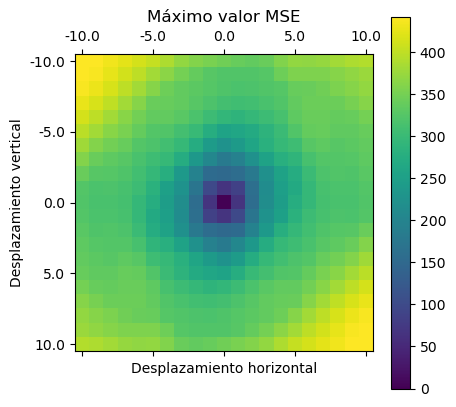

In [59]:
MSE_max = max_results["MSE"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in MSE_max.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.MSE #if not np.isnan(row.SSIM) else 1
plt.matshow(m)

ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Máximo valor MSE")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/2371216300.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/2371216300.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


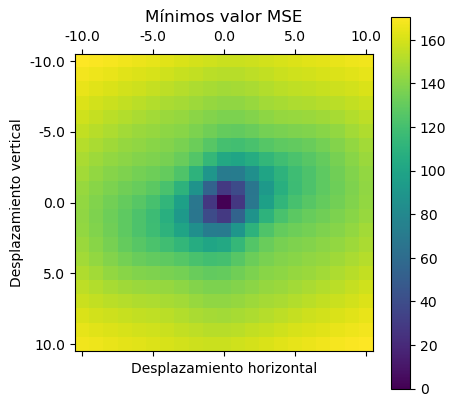

In [60]:
MSE_min = min_results["MSE"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in MSE_avg.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.MSE #if not np.isnan(row.SSIM) else 1
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Mínimos valor MSE")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

# PERCEPTNET

/tmp/uv0755/ipykernel_73428/523921098.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/523921098.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


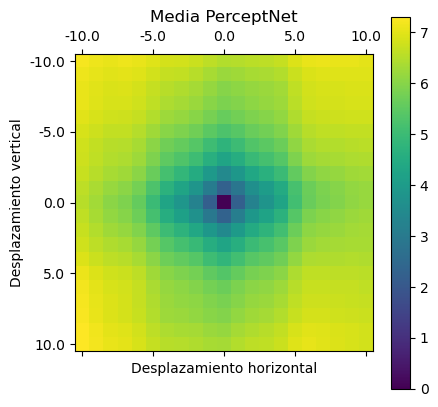

In [61]:
PN_avg = avg_results["PerceptNet"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in PN_avg.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.PerceptNet #if not np.isnan(row.SSIM) else 1
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Media PerceptNet")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/296410398.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/296410398.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


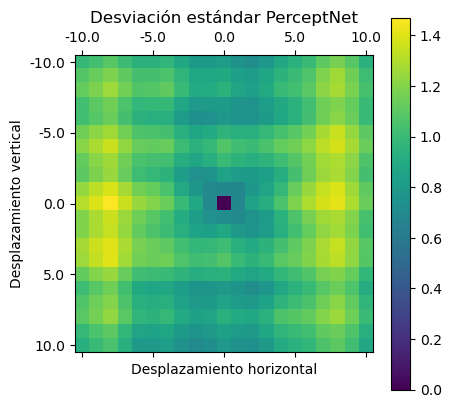

In [62]:
PN_std = std_results["PerceptNet"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in PN_std.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.PerceptNet #if not np.isnan(row.SSIM) else 1
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Desviación estándar PerceptNet")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/3971588313.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/3971588313.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


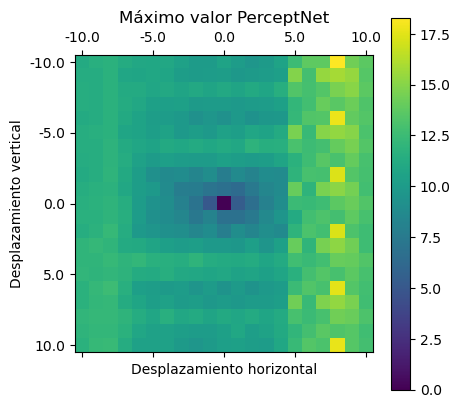

In [63]:
PN_max = max_results["PerceptNet"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in PN_max.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.PerceptNet #if not np.isnan(row.SSIM) else 1
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Máximo valor PerceptNet")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()

/tmp/uv0755/ipykernel_73428/2695744072.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticks-10)
/tmp/uv0755/ipykernel_73428/2695744072.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ticks-10)


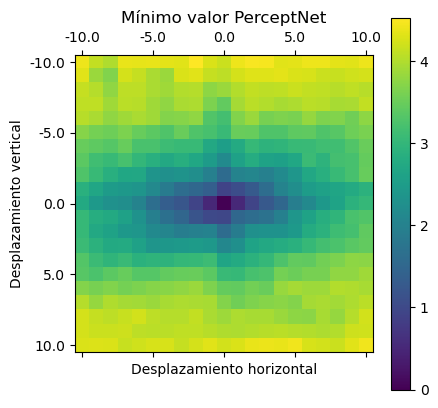

In [64]:
PN_min = min_results["PerceptNet"].reset_index()
m = np.zeros(shape=(21,21))
for i, row in PN_min.iterrows():
    i, j = int(row.level_0+10), int(row.level_1+10)
    m[i,j] = row.PerceptNet #if not np.isnan(row.SSIM) else 1
plt.matshow(m)
ax = plt.gca()
ticks = ax.get_xticks()
ax.set_xticklabels(ticks-10)
ax.set_yticklabels(ticks-10)
plt.title("Mínimo valor PerceptNet")
plt.xlabel("Desplazamiento horizontal")
plt.ylabel("Desplazamiento vertical")
plt.colorbar()
plt.show()